# Preprocessing Module - Basic Usage Guide

This notebook demonstrates the basic functionality of the `fin_statement_model.preprocessing` module, which provides tools for cleaning, normalizing, transforming, and formatting financial data.

**Important**: Run cells in order! Make sure to execute the imports cell first, as later cells depend on the imported modules and created variables.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Basic Normalization](#normalization)
3. [Time Series Transformations](#time-series)
4. [Period Conversions](#period-conversions)
5. [Transformation Pipelines](#pipelines)
6. [Custom Transformers](#custom-transformers)
7. [Error Handling](#error-handling)
8. [Best Practices](#best-practices)


## 1. Setup and Imports <a id="setup"></a>


In [55]:
# Standard library imports
import warnings
warnings.filterwarnings('ignore')

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# fin_statement_model imports
from fin_statement_model.preprocessing import (
    TransformationService,
    TransformerFactory,
    DataTransformer,
    CompositeTransformer
)
from fin_statement_model.preprocessing.transformers import (
    NormalizationTransformer,
    TimeSeriesTransformer,
    PeriodConversionTransformer
)
from fin_statement_model.preprocessing.config import (
    NormalizationConfig,
    TimeSeriesConfig,
    PeriodConversionConfig
)

# Set display options for better output
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 10)

print("✅ Imports successful!")
print(f"📋 Available transformers: {TransformerFactory.list_transformers()}")


✅ Imports successful!
📋 Available transformers: ['NormalizationTransformer', 'normalization', 'PeriodConversionTransformer', 'period_conversion', 'TimeSeriesTransformer', 'time_series', 'ratio', 'ratio_v2', 'growth_limiter', 'margin_calculator']


### Create Sample Financial Data

We'll create quarterly income statement data to demonstrate various preprocessing operations.


📊 Quarterly Income Statement Data:
            revenue  cogs  opex  sga  r_and_d  gross_profit  net_income
2022-03-31     1000   600   200  100       50           400          50
2022-06-30     1100   650   220  110       55           450          65
2022-09-30     1200   700   240  120       60           500          80
2022-12-31     1300   750   260  130       65           550          95
2023-03-31     1400   800   280  140       70           600         110

📈 Data shape: (8, 7)
📅 Date range: 2022-03-31 00:00:00 to 2023-12-31 00:00:00


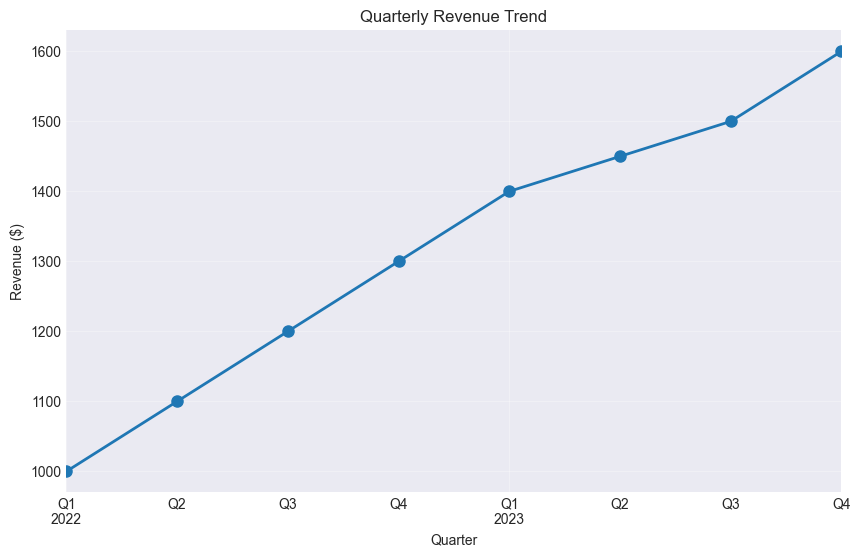

In [56]:
# Create sample quarterly income statement data
quarterly_data = pd.DataFrame({
    'revenue': [1000, 1100, 1200, 1300, 1400, 1450, 1500, 1600],
    'cogs': [600, 650, 700, 750, 800, 820, 850, 900],
    'opex': [200, 220, 240, 260, 280, 290, 300, 320],
    'sga': [100, 110, 120, 130, 140, 145, 150, 160],
    'r_and_d': [50, 55, 60, 65, 70, 72, 75, 80]
}, index=pd.date_range('2022-03-31', periods=8, freq='QE'))

# Calculate gross profit and net income
quarterly_data['gross_profit'] = quarterly_data['revenue'] - quarterly_data['cogs']
quarterly_data['net_income'] = (quarterly_data['gross_profit'] - 
                                quarterly_data['opex'] - 
                                quarterly_data['sga'] - 
                                quarterly_data['r_and_d'])

print("📊 Quarterly Income Statement Data:")
print(quarterly_data.head())
print(f"\n📈 Data shape: {quarterly_data.shape}")
print(f"📅 Date range: {quarterly_data.index[0]} to {quarterly_data.index[-1]}")

# Visualize revenue trend
quarterly_data['revenue'].plot(kind='line', marker='o', markersize=8, linewidth=2)
plt.title('Quarterly Revenue Trend')
plt.ylabel('Revenue ($)')
plt.xlabel('Quarter')
plt.grid(True, alpha=0.3)
plt.show()


### Initialize the Transformation Service

The `TransformationService` provides a high-level API for common preprocessing operations.


In [57]:
# Initialize the transformation service
service = TransformationService()
print("✅ TransformationService initialized and ready!")


✅ TransformationService initialized and ready!


## 2. Basic Normalization <a id="normalization"></a>

The normalization transformer offers several methods to make financial data comparable across different scales:
- **Percent of Reference**: Express values as percentages (common-size analysis)
- **Scale By Factor**: Convert units (e.g., to thousands or millions)
- **Min-Max**: Scale to [0,1] range
- **Standard**: Z-score normalization


### 2.1 Percent of Reference (Common-Size Analysis)


📊 Income Statement as % of Revenue:
            revenue  cogs  gross_profit  opex  net_income
2022-03-31     1000 60.00         40.00 20.00        5.00
2022-06-30     1100 59.09         40.91 20.00        5.91
2022-09-30     1200 58.33         41.67 20.00        6.67
2022-12-31     1300 57.69         42.31 20.00        7.31
2023-03-31     1400 57.14         42.86 20.00        7.86


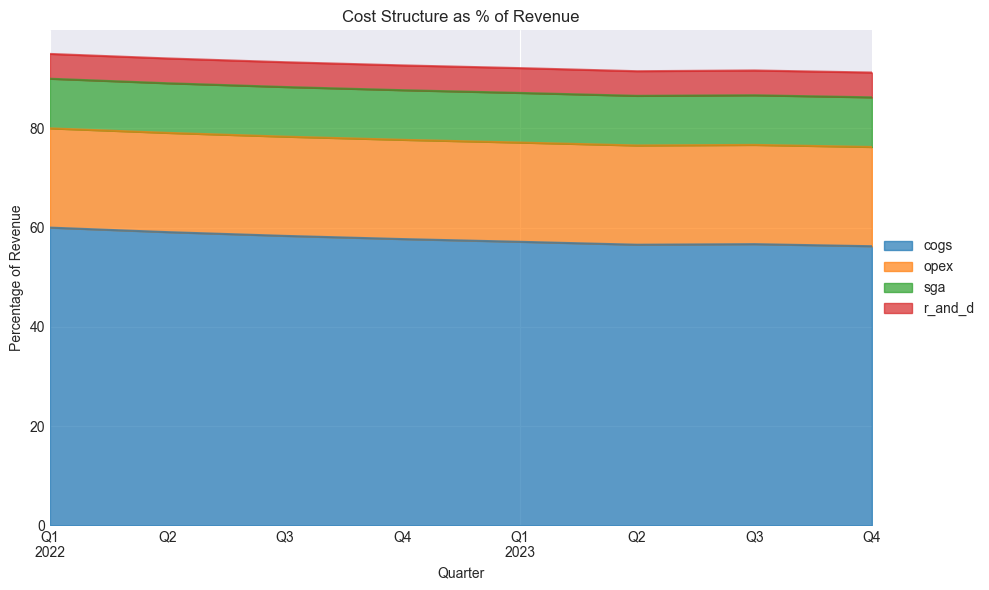


✅ Direct transformer usage produces same result: True


In [58]:
# Express all income statement items as percentage of revenue
percent_of_revenue = service.normalize_data(
    quarterly_data,
    normalization_type='percent_of',
    reference='revenue'
)

print("📊 Income Statement as % of Revenue:")
print(percent_of_revenue[['revenue', 'cogs', 'gross_profit', 'opex', 'net_income']].head())

# Visualize cost structure over time
cost_columns = ['cogs', 'opex', 'sga', 'r_and_d']
percent_of_revenue[cost_columns].plot(
    kind='area', 
    stacked=True,
    title='Cost Structure as % of Revenue',
    ylabel='Percentage of Revenue',
    xlabel='Quarter',
    alpha=0.7
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Alternative: Using NormalizationTransformer directly with config
config = NormalizationConfig.percent_of('revenue')
normalizer = NormalizationTransformer(config=config)
result = normalizer.transform(quarterly_data)
print("\n✅ Direct transformer usage produces same result:", 
      result.equals(percent_of_revenue))


### 2.2 Scale By Factor (Unit Conversion)


In [59]:
# Convert values to thousands and millions
scaled_to_thousands = service.normalize_data(
    quarterly_data,
    normalization_type='scale_by',
    scale_factor=0.001  # Divide by 1000
)

scaled_to_millions = service.normalize_data(
    quarterly_data,
    normalization_type='scale_by',
    scale_factor=0.000001  # Divide by 1,000,000
)

print("💰 Original values:")
print(quarterly_data[['revenue', 'net_income']].head(3))

print("\n📉 Values in thousands (K):")
print(scaled_to_thousands[['revenue', 'net_income']].head(3))

print("\n📉 Values in millions (M):")
print(scaled_to_millions[['revenue', 'net_income']].head(3))


💰 Original values:
            revenue  net_income
2022-03-31     1000          50
2022-06-30     1100          65
2022-09-30     1200          80

📉 Values in thousands (K):
            revenue  net_income
2022-03-31     1.00        0.05
2022-06-30     1.10        0.07
2022-09-30     1.20        0.08

📉 Values in millions (M):
            revenue  net_income
2022-03-31     0.00        0.00
2022-06-30     0.00        0.00
2022-09-30     0.00        0.00


### 2.3 Min-Max and Standard Normalization


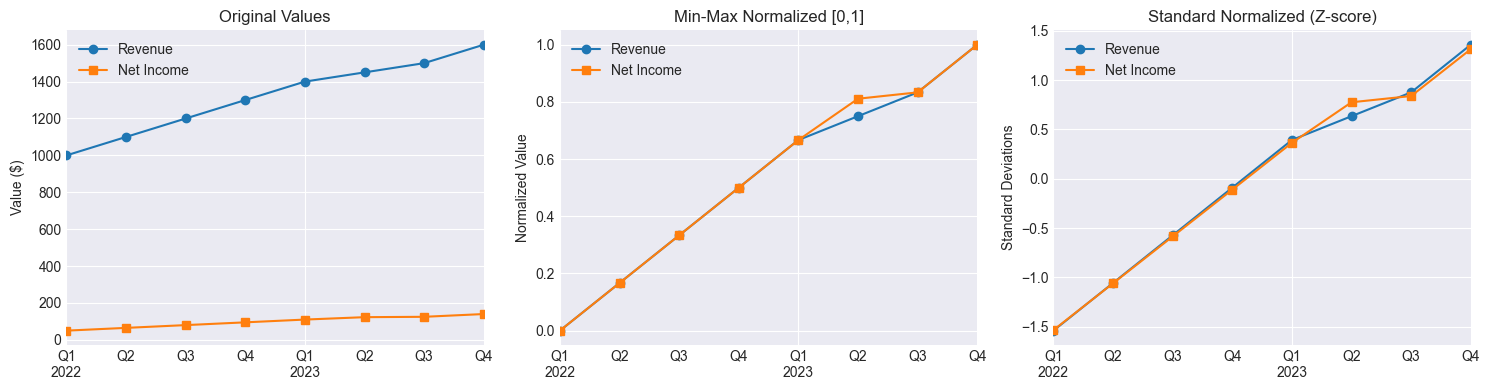

📊 Summary Statistics:
Min-Max range: [0.00, 1.00]
Standard mean: 0.000000 (should be ~0)
Standard std: 1.000000 (should be ~1)


In [60]:
# Min-Max normalization (scale to [0,1] range)
minmax_normalized = service.normalize_data(
    quarterly_data[['revenue', 'cogs', 'net_income']],
    normalization_type='minmax'
)

# Standard normalization (z-score)
standard_normalized = service.normalize_data(
    quarterly_data[['revenue', 'cogs', 'net_income']],
    normalization_type='standard'
)

# Compare normalization methods
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original data
quarterly_data['revenue'].plot(ax=axes[0], marker='o', label='Revenue')
quarterly_data['net_income'].plot(ax=axes[0], marker='s', label='Net Income')
axes[0].set_title('Original Values')
axes[0].set_ylabel('Value ($)')
axes[0].legend()

# Min-Max normalized
minmax_normalized['revenue'].plot(ax=axes[1], marker='o', label='Revenue')
minmax_normalized['net_income'].plot(ax=axes[1], marker='s', label='Net Income')
axes[1].set_title('Min-Max Normalized [0,1]')
axes[1].set_ylabel('Normalized Value')
axes[1].legend()

# Standard normalized
standard_normalized['revenue'].plot(ax=axes[2], marker='o', label='Revenue')
standard_normalized['net_income'].plot(ax=axes[2], marker='s', label='Net Income')
axes[2].set_title('Standard Normalized (Z-score)')
axes[2].set_ylabel('Standard Deviations')
axes[2].legend()

plt.tight_layout()
plt.show()

print("📊 Summary Statistics:")
print(f"Min-Max range: [{minmax_normalized.min().min():.2f}, {minmax_normalized.max().max():.2f}]")
print(f"Standard mean: {standard_normalized.mean().mean():.6f} (should be ~0)")
print(f"Standard std: {standard_normalized.std().mean():.6f} (should be ~1)")


## 3. Time Series Transformations <a id="time-series"></a>

Time series transformations help identify trends, growth patterns, and period-over-period changes:
- **Growth Rate**: Period-over-period percentage change
- **YoY/QoQ**: Year-over-Year and Quarter-over-Quarter comparisons
- **Moving Average**: Smooth out short-term fluctuations
- **CAGR**: Compound Annual Growth Rate


### 3.1 Quarter-over-Quarter (QoQ) Growth


📈 Quarter-over-Quarter Growth Rates (%):
            revenue_qoq  cogs_qoq  net_income_qoq
2022-06-30        10.00      8.33           30.00
2022-09-30         9.09      7.69           23.08
2022-12-31         8.33      7.14           18.75
2023-03-31         7.69      6.67           15.79
2023-06-30         3.57      2.50           11.82
2023-09-30         3.45      3.66            1.63
2023-12-31         6.67      5.88           12.00


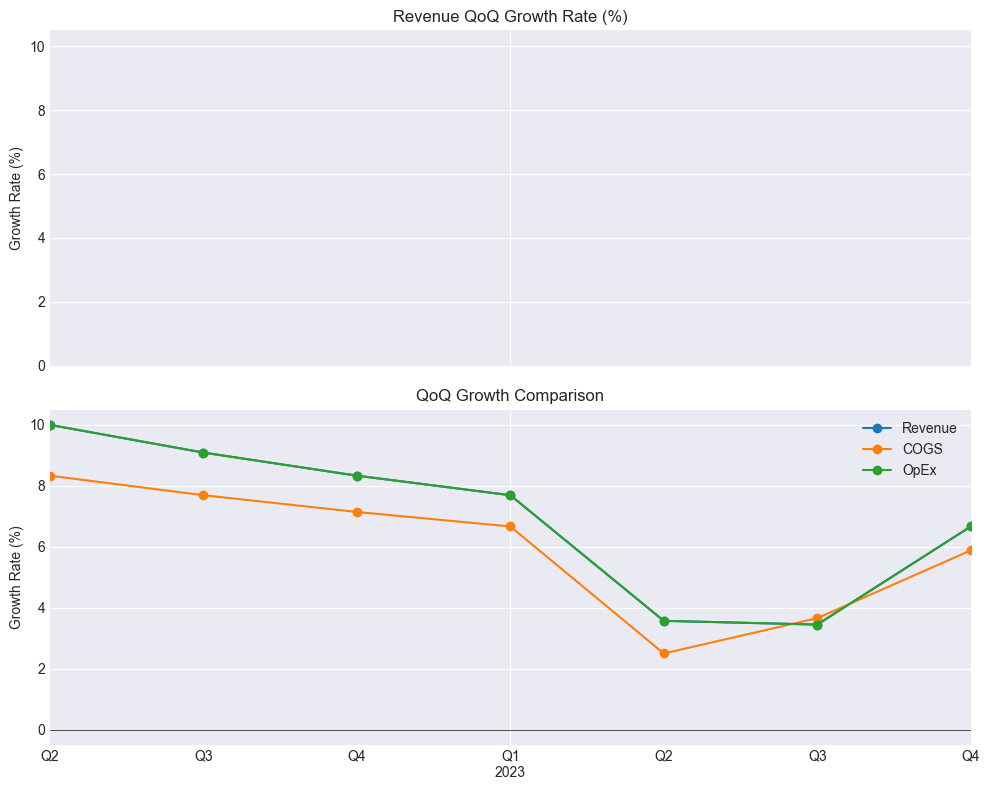

In [61]:
# Calculate QoQ growth rates
qoq_growth = service.transform_time_series(
    quarterly_data,
    transformation_type='qoq',
    periods=1  # Compare to previous quarter
)

print("📈 Quarter-over-Quarter Growth Rates (%):")
growth_cols = ['revenue_qoq', 'cogs_qoq', 'net_income_qoq']
print(qoq_growth[growth_cols].dropna())

# Visualize QoQ growth trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Revenue QoQ growth
qoq_growth['revenue_qoq'].dropna().plot(
    ax=ax1, kind='bar', color='green', alpha=0.7,
    title='Revenue QoQ Growth Rate (%)'
)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_ylabel('Growth Rate (%)')

# Compare multiple metrics
qoq_growth[['revenue_qoq', 'cogs_qoq', 'opex_qoq']].dropna().plot(
    ax=ax2, kind='line', marker='o', 
    title='QoQ Growth Comparison'
)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Growth Rate (%)')
ax2.legend(['Revenue', 'COGS', 'OpEx'])

plt.tight_layout()
plt.show()


### 3.2 Year-over-Year (YoY) Growth


📊 Year-over-Year Growth Rates (%):
            revenue_yoy  net_income_yoy
2023-03-31        40.00          120.00
2023-06-30        31.82           89.23
2023-09-30        25.00           56.25
2023-12-31        23.08           47.37


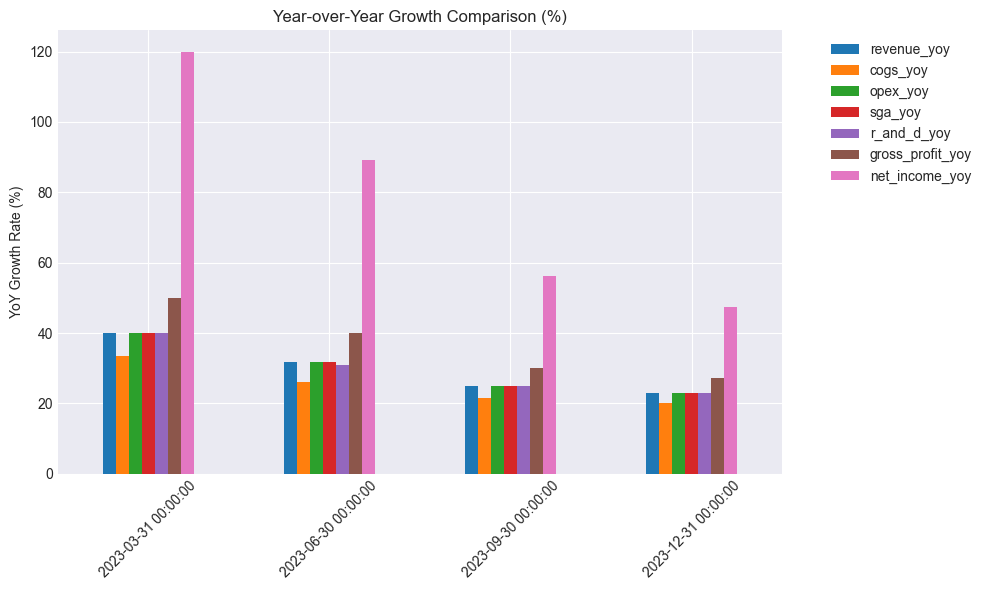

In [62]:
# Calculate YoY growth (comparing to same quarter last year)
yoy_growth = service.transform_time_series(
    quarterly_data,
    transformation_type='yoy',
    periods=4  # 4 quarters back for quarterly data
)

print("📊 Year-over-Year Growth Rates (%):")
print(yoy_growth[['revenue_yoy', 'net_income_yoy']].iloc[4:])  # First 4 periods are NaN

# Alternative: Using TimeSeriesConfig
config = TimeSeriesConfig.yoy(periods=4)
yoy_transformer = TimeSeriesTransformer(config=config)
yoy_result = yoy_transformer.transform(quarterly_data)

# Visualize YoY growth
yoy_cols = [col for col in yoy_result.columns if col.endswith('_yoy')]
yoy_result[yoy_cols].iloc[4:].plot(
    kind='bar',
    title='Year-over-Year Growth Comparison (%)',
    ylabel='YoY Growth Rate (%)',
    figsize=(10, 6),
    rot=45
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 3.3 Moving Averages and CAGR


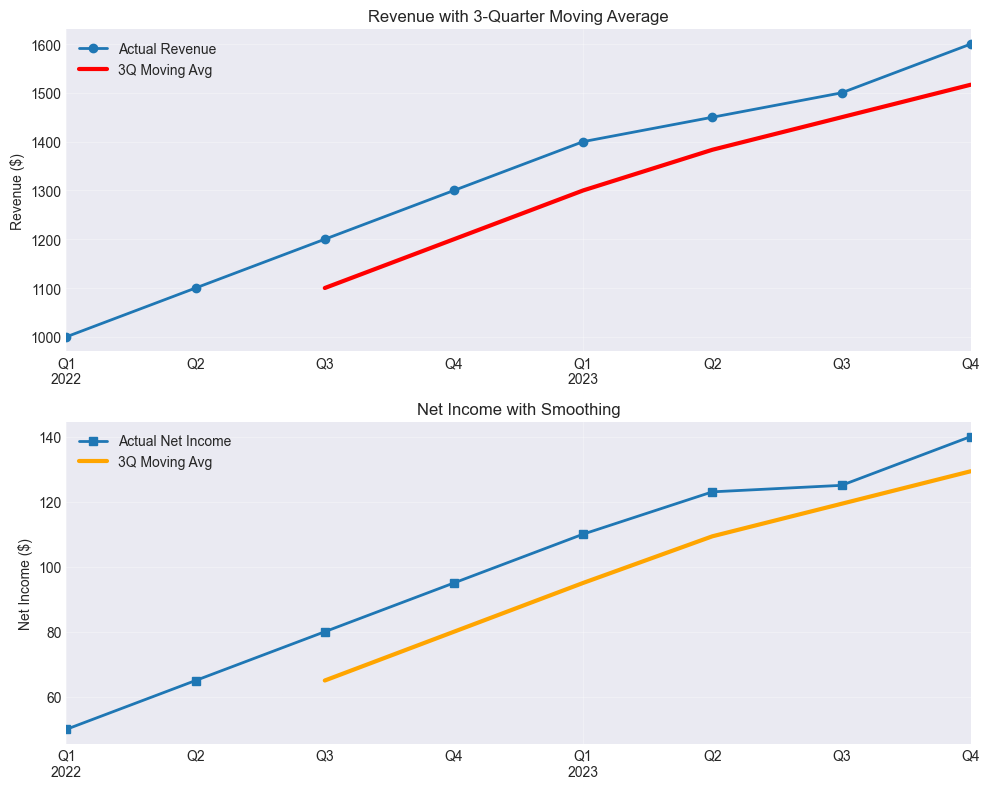


📈 Compound Annual Growth Rates (%):
revenue: 6.94%
cogs: 5.96%
opex: 6.94%
sga: 6.94%
r_and_d: 6.94%
gross_profit: 8.32%
net_income: 15.85%


In [63]:
# Calculate 3-quarter moving average
moving_avg = service.transform_time_series(
    quarterly_data,
    transformation_type='moving_avg',
    window_size=3
)

# Calculate Compound Annual Growth Rate (CAGR)
cagr = service.transform_time_series(
    quarterly_data,
    transformation_type='cagr'
)

# Visualize moving average smoothing
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Revenue with moving average
quarterly_data['revenue'].plot(ax=ax1, marker='o', label='Actual Revenue', linewidth=2)
moving_avg['revenue_ma3'].plot(ax=ax1, linewidth=3, label='3Q Moving Avg', color='red')
ax1.set_title('Revenue with 3-Quarter Moving Average')
ax1.set_ylabel('Revenue ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Net income volatility
quarterly_data['net_income'].plot(ax=ax2, marker='s', label='Actual Net Income', linewidth=2)
moving_avg['net_income_ma3'].plot(ax=ax2, linewidth=3, label='3Q Moving Avg', color='orange')
ax2.set_title('Net Income with Smoothing')
ax2.set_ylabel('Net Income ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display CAGR results
print("\n📈 Compound Annual Growth Rates (%):")
cagr_cols = [col for col in cagr.columns if col.endswith('_cagr')]
for col in cagr_cols:
    base_col = col.replace('_cagr', '')
    print(f"{base_col}: {cagr[col].iloc[0]:.2f}%")


## 4. Period Conversions <a id="period-conversions"></a>

Convert data between different reporting periods (quarterly → annual, monthly → quarterly, etc.):
- Choose appropriate aggregation methods based on the metric type:
  - **Flow measures** (revenue, expenses): Use 'sum'
  - **Balance sheet items**: Use 'last' (point-in-time)
  - **Rates/ratios**: Consider 'mean'


### 4.1 Quarterly to Annual Conversion


📊 Annual Financial Summary:
            revenue  cogs  net_income
2022-12-31     4600  2700         290
2023-12-31     5950  3370         498

💰 Year-End Balance Sheet Values:
            total_assets  total_equity  cash
2022-12-31          5300          3150   560
2023-12-31          5700          3350   640


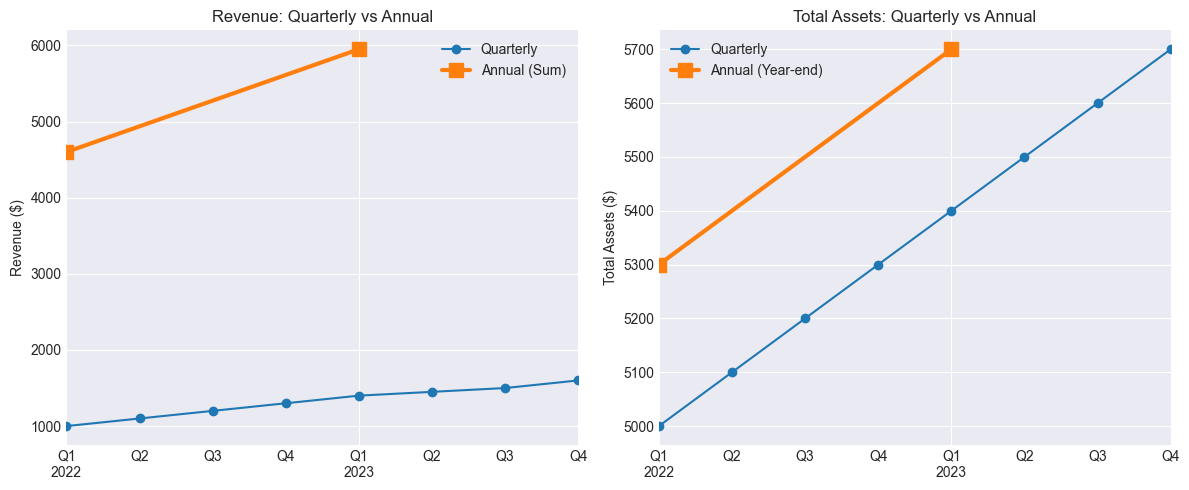

In [64]:
# Convert quarterly data to annual (summing flow items)
annual_data = service.convert_periods(
    quarterly_data,
    conversion_type='quarterly_to_annual',
    aggregation='sum'
)

print("📊 Annual Financial Summary:")
print(annual_data[['revenue', 'cogs', 'net_income']])

# Create sample balance sheet data (point-in-time)
balance_sheet = pd.DataFrame({
    'total_assets': [5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700],
    'total_equity': [3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350],
    'cash': [500, 520, 540, 560, 580, 600, 620, 640]
}, index=quarterly_data.index)

# Convert balance sheet using 'last' to get year-end values
annual_bs = service.convert_periods(
    balance_sheet,
    conversion_type='quarterly_to_annual',
    aggregation='last'
)

print("\n💰 Year-End Balance Sheet Values:")
print(annual_bs)

# Visualize quarterly vs annual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Flow items (sum)
quarterly_data['revenue'].plot(ax=ax1, marker='o', label='Quarterly')
annual_data['revenue'].plot(ax=ax1, marker='s', markersize=10, 
                            linewidth=3, label='Annual (Sum)')
ax1.set_title('Revenue: Quarterly vs Annual')
ax1.set_ylabel('Revenue ($)')
ax1.legend()

# Balance sheet items (last)
balance_sheet['total_assets'].plot(ax=ax2, marker='o', label='Quarterly')
annual_bs['total_assets'].plot(ax=ax2, marker='s', markersize=10, 
                               linewidth=3, label='Annual (Year-end)')
ax2.set_title('Total Assets: Quarterly vs Annual')
ax2.set_ylabel('Total Assets ($)')
ax2.legend()

plt.tight_layout()
plt.show()


### 4.2 Trailing Twelve Months (TTM)


📊 Trailing Twelve Months (TTM) Analysis:
Note: First 3 quarters are NaN (need 4 quarters for TTM)
            revenue  net_income
2022-12-31  4600.00      290.00
2023-03-31  5000.00      350.00
2023-06-30  5350.00      408.00
2023-09-30  5650.00      453.00
2023-12-31  5950.00      498.00


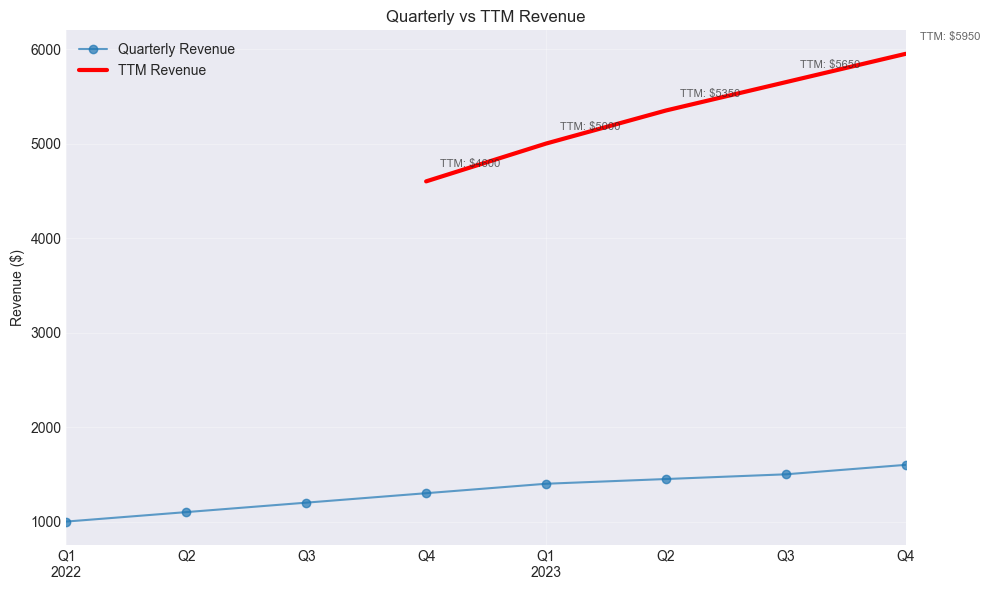


✅ Direct transformer produces same result: True


In [65]:
# Calculate TTM (Trailing Twelve Months) for quarterly data
ttm_data = service.convert_periods(
    quarterly_data,
    conversion_type='quarterly_to_ttm',
    aggregation='sum'  # TTM always uses sum
)

print("📊 Trailing Twelve Months (TTM) Analysis:")
print("Note: First 3 quarters are NaN (need 4 quarters for TTM)")
print(ttm_data[['revenue', 'net_income']].iloc[3:])

# Visualize TTM vs Quarterly
fig, ax = plt.subplots(figsize=(10, 6))

# Plot quarterly and TTM revenue
quarterly_data['revenue'].plot(ax=ax, marker='o', label='Quarterly Revenue', alpha=0.7)
ttm_data['revenue'].plot(ax=ax, linewidth=3, label='TTM Revenue', color='red')

ax.set_title('Quarterly vs TTM Revenue')
ax.set_ylabel('Revenue ($)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add annotations
for i in range(3, len(ttm_data)):
    ax.annotate(f"TTM: ${ttm_data['revenue'].iloc[i]:.0f}",
                xy=(ttm_data.index[i], ttm_data['revenue'].iloc[i]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Alternative: Using PeriodConversionConfig
config = PeriodConversionConfig.quarterly_to_ttm()
ttm_transformer = PeriodConversionTransformer(config=config)
ttm_result = ttm_transformer.transform(quarterly_data)
print("\n✅ Direct transformer produces same result:", ttm_result.equals(ttm_data))


## 5. Transformation Pipelines <a id="pipelines"></a>

Chain multiple transformations together to create complex data processing workflows.


📊 Pipeline Result: Annual YoY Growth Rates (averaged)
            revenue  net_income  revenue_yoy  net_income_yoy
2022-12-31     0.00        0.00          NaN             NaN
2023-12-31     0.00        0.00        29.97           78.21

📈 Composite Transformer Result (first 5 rows):
            revenue  cogs  opex  revenue_ma3  cogs_ma3  opex_ma3
2022-03-31      NaN   NaN   NaN          NaN       NaN       NaN
2022-06-30      NaN   NaN   NaN          NaN       NaN       NaN
2022-09-30   109.09 63.64 21.82         1.10     59.09     20.00
2022-12-31   108.33 62.50 21.67         1.20     58.33     20.00
2023-03-31   107.69 61.54 21.54         1.30     57.69     20.00


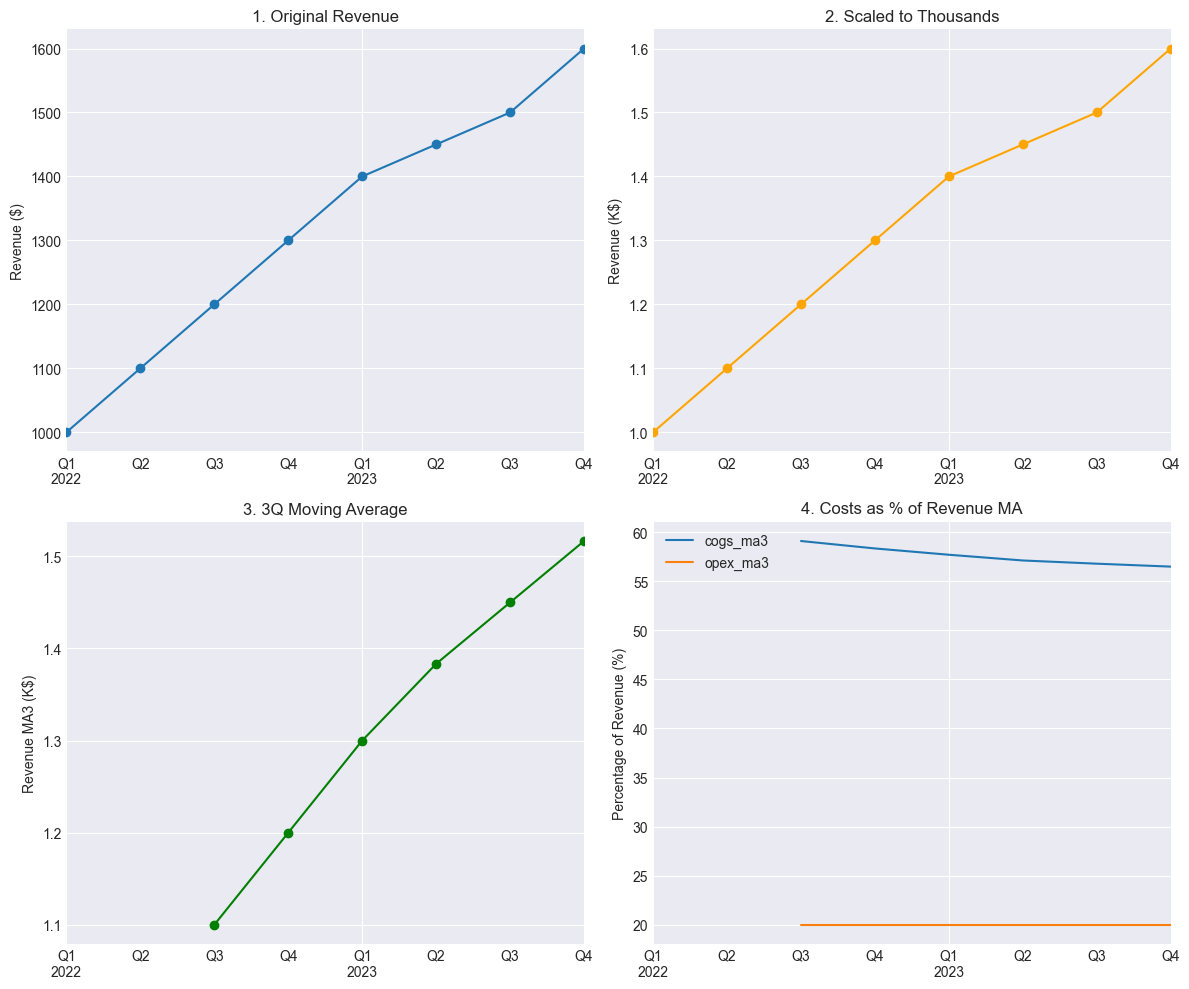

In [66]:
# Example 1: Scale to millions → Calculate YoY → Convert to annual
pipeline_config = [
    {
        'name': 'normalization',
        'normalization_type': 'scale_by',
        'scale_factor': 0.000001  # Convert to millions
    },
    {
        'name': 'time_series',
        'transformation_type': 'yoy',
        'periods': 4  # YoY for quarterly data
    },
    {
        'name': 'period_conversion', 
        'conversion_type': 'quarterly_to_annual',
        'aggregation': 'mean'  # Average YoY rate for the year
    }
]

pipeline_result = service.apply_transformation_pipeline(
    quarterly_data[['revenue', 'net_income']],
    pipeline_config
)

print("📊 Pipeline Result: Annual YoY Growth Rates (averaged)")
print(pipeline_result)

# Example 2: Using CompositeTransformer directly
# Normalize → Moving Average → Percent of Reference
normalizer = NormalizationTransformer(
    normalization_type='scale_by',
    scale_factor=0.001  # to thousands
)
ma_transformer = TimeSeriesTransformer(
    transformation_type='moving_avg',
    window_size=3
)
percent_transformer = NormalizationTransformer(
    normalization_type='percent_of',
    reference='revenue_ma3'
)

# Create composite transformer
composite = CompositeTransformer([normalizer, ma_transformer, percent_transformer])
composite_result = composite.execute(quarterly_data[['revenue', 'cogs', 'opex']])

print("\n📈 Composite Transformer Result (first 5 rows):")
print(composite_result.head())

# Visualize pipeline effect
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original data
quarterly_data['revenue'].plot(ax=axes[0,0], marker='o', title='1. Original Revenue')
axes[0,0].set_ylabel('Revenue ($)')

# After scaling
scaled = normalizer.execute(quarterly_data[['revenue']])
scaled['revenue'].plot(ax=axes[0,1], marker='o', color='orange', 
                      title='2. Scaled to Thousands')
axes[0,1].set_ylabel('Revenue (K$)')

# After moving average
ma_result = ma_transformer.execute(scaled)
ma_result['revenue_ma3'].plot(ax=axes[1,0], marker='o', color='green',
                              title='3. 3Q Moving Average')
axes[1,0].set_ylabel('Revenue MA3 (K$)')

# Final: as percent of revenue
composite_result[['cogs_ma3', 'opex_ma3']].plot(ax=axes[1,1],
                                                title='4. Costs as % of Revenue MA')
axes[1,1].set_ylabel('Percentage of Revenue (%)')

plt.tight_layout()
plt.show()


In [67]:
# Helper function for safe transformer registration in Jupyter
def safe_register_transformer(name, transformer_class):
    """Safely register a transformer, handling re-runs in Jupyter."""
    try:
        # Check if already registered
        existing_class = TransformerFactory.get_transformer_class(name)
        # If the class names match, skip registration
        if existing_class.__name__ == transformer_class.__name__:
            print(f"ℹ️ Transformer '{name}' already registered, skipping...")
            return
    except:
        # Not registered yet, proceed
        pass
    
    # Register the transformer
    TransformerFactory.register_transformer(name, transformer_class)
    print(f"✅ Successfully registered transformer: {name}")

# Example 1: Simple growth rate limiter
class GrowthRateLimiterTransformer(DataTransformer):
    """Limits growth rates to a specified maximum percentage."""
    
    def __init__(self, max_growth_rate=50.0, **kwargs):
        super().__init__({'max_growth_rate': max_growth_rate})
        self.max_growth_rate = max_growth_rate
    
    def _transform_impl(self, data):
        df, was_series = self._coerce_to_dataframe(data)
        result = df.copy()
        
        # Calculate growth rates
        for col in df.columns:
            growth = df[col].pct_change() * 100
            # Limit growth rates
            growth = growth.clip(upper=self.max_growth_rate)
            result[f"{col}_limited_growth"] = growth
        
        if was_series:
            return result.iloc[:, 0]
        return result
    
    def validate_input(self, data):
        return isinstance(data, (pd.DataFrame, pd.Series))

# Safely register the transformer
safe_register_transformer('growth_limiter', GrowthRateLimiterTransformer)

# Use the custom transformer
growth_limiter = TransformerFactory.create_transformer(
    'growth_limiter',
    max_growth_rate=25.0
)

limited_growth = growth_limiter.execute(quarterly_data[['revenue', 'net_income']])
print("📊 Limited Growth Rates (max 25%):")
print(limited_growth.dropna())


ℹ️ Transformer 'growth_limiter' already registered, skipping...
📊 Limited Growth Rates (max 25%):
            revenue  net_income  revenue_limited_growth  \
2022-06-30     1100          65                   10.00   
2022-09-30     1200          80                    9.09   
2022-12-31     1300          95                    8.33   
2023-03-31     1400         110                    7.69   
2023-06-30     1450         123                    3.57   
2023-09-30     1500         125                    3.45   
2023-12-31     1600         140                    6.67   

            net_income_limited_growth  
2022-06-30                      25.00  
2022-09-30                      23.08  
2022-12-31                      18.75  
2023-03-31                      15.79  
2023-06-30                      11.82  
2023-09-30                       1.63  
2023-12-31                      12.00  


ℹ️ Transformer 'margin_calculator' already registered, skipping...
📊 Calculated Margins:
            gross_profit_margin  net_income_margin
2022-03-31                40.00               5.00
2022-06-30                40.91               5.91
2022-09-30                41.67               6.67
2022-12-31                42.31               7.31
2023-03-31                42.86               7.86


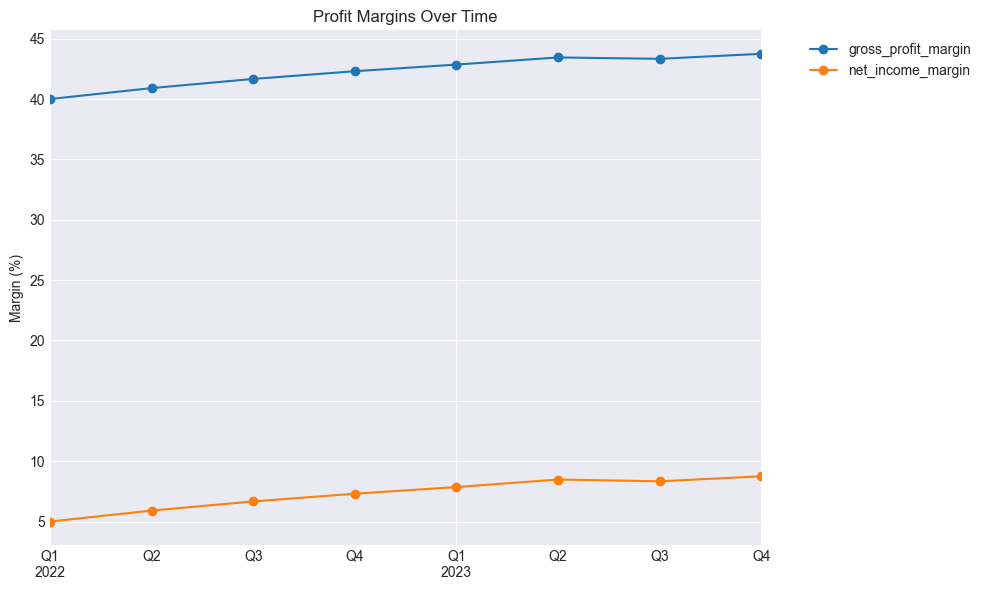

In [68]:
# Example 2: Margin calculator transformer
class MarginCalculatorTransformer(DataTransformer):
    """Calculates various profit margins."""
    
    def __init__(self, revenue_col='revenue', **kwargs):
        super().__init__({'revenue_col': revenue_col})
        self.revenue_col = revenue_col
    
    def _transform_impl(self, data):
        df, was_series = self._coerce_to_dataframe(data)
        
        if self.revenue_col not in df.columns:
            raise ValueError(f"Revenue column '{self.revenue_col}' not found")
        
        result = df.copy()
        
        # Calculate margins for any column that looks like profit/income
        for col in df.columns:
            if any(term in col.lower() for term in ['profit', 'income', 'earnings']):
                margin_col = f"{col}_margin"
                result[margin_col] = (df[col] / df[self.revenue_col]) * 100
        
        if was_series:
            return result.iloc[:, 0]
        return result
    
    def validate_input(self, data):
        return isinstance(data, (pd.DataFrame, pd.Series))

# Safely register
safe_register_transformer('margin_calculator', MarginCalculatorTransformer)

# Use the margin calculator
margin_calc = TransformerFactory.create_transformer('margin_calculator')
margins = margin_calc.execute(quarterly_data)

print("📊 Calculated Margins:")
margin_cols = [col for col in margins.columns if col.endswith('_margin')]
print(margins[margin_cols].head())

# Visualize margins over time
margins[margin_cols].plot(
    kind='line',
    marker='o',
    title='Profit Margins Over Time',
    ylabel='Margin (%)',
    figsize=(10, 6)
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 8. Best Practices <a id="best-practices"></a>

Here are key recommendations for using the preprocessing module effectively:


### 1. Data Quality Checks

Always validate your data before transformation:
- Ensure proper index types (DatetimeIndex for time series)
- Handle missing values appropriately
- Check for zero/negative values when using percent transformations

### 2. Choose the Right Aggregation Method

For period conversions:
- **Flow measures** (revenue, expenses): Use `'sum'`
- **Balance sheet items**: Use `'last'` for end-of-period values
- **Rates and ratios**: Consider `'mean'` or `'last'`

### 3. Performance Optimization

- Use `CompositeTransformer` for multiple operations (avoids intermediate copies)
- Pre-filter columns to transform only what's needed
- Consider chunking for very large datasets

### 4. Configuration Management

- Use Pydantic config models for type safety
- Store common configurations in variables or files
- Validate parameters before transformation

### 5. Error Handling

- Use try-except blocks around transformations
- Check for specific error types when using transformers directly
- Walk the exception chain to find root causes
- Validate data before transformation to avoid errors

### 6. Custom Transformers in Jupyter

- Use the `safe_register_transformer()` helper function
- Check class names to avoid re-registration errors
- Consider clearing the transformer registry if needed

### 7. Documentation and Testing

- Document expected input/output formats
- Include examples in docstrings
- Test edge cases (empty data, single row, missing values)
- Validate transformer behavior with known inputs


## Summary

You've learned the key features of the preprocessing module:

✅ **Normalization**: Express data as percentages, scale units, or standardize values  
✅ **Time Series**: Calculate growth rates, moving averages, YoY/QoQ comparisons  
✅ **Period Conversions**: Convert between quarterly/annual periods with proper aggregation  
✅ **Pipelines**: Chain multiple transformations for complex workflows  
✅ **Custom Transformers**: Extend functionality with your own transformations  
✅ **Error Handling**: Catch and handle various preprocessing errors  

### Next Steps

1. Explore the [preprocessing README](../../../fin_statement_model/preprocessing/README.md) for more details
2. Check out individual transformer implementations in the source code
3. Build custom transformers for your specific use cases
4. Integrate preprocessing into your financial analysis workflows

Happy preprocessing! 🚀
